In [154]:
# TODO
# handle missing values, handle outliers
# train every model (optional: cross-validation or hyperparameter tuning)
# visualize model accuracy
# reiterate cleaning over New Customer dataset
# use model on New Customer, and save/ output the result

In [155]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
# import data
TrainData = pd.read_csv("Train Data.csv", delimiter = ',', header = 0, index_col = 0)
#TrainData
numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
categorical_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area", "Loan_Status"]
categorical_features_wout_target = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area"]
features = [
"Gender",              
"Married",             
"Dependents",           
"Education",           
"Self_Employed" ,       
"ApplicantIncome",       
"CoapplicantIncome",     
"LoanAmount",    
"Loan_Amount_Term",   
"Credit_History", 
"Property_Area"
]
target = "Loan_Status"

In [157]:
# data cleaning


# handle missing values
#print(TrainData.isnull().sum())
TrainData.drop(index=[row for row in TrainData.index 
                    if pd.isna(TrainData.loc[row, 'Married'])], inplace=True)

numeric_null_features = ["LoanAmount", "Loan_Amount_Term"]
categorical_null_features = ["Gender", #"Married", 
                             "Dependents", "Self_Employed", "Credit_History"]
#print(TrainData.isnull().sum())

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

TrainData[numerical_features] = SimpleImputer(strategy="mean").fit_transform(TrainData[numerical_features])
TrainData[numerical_features] = MinMaxScaler().fit_transform(TrainData[numerical_features])
TrainData[categorical_features] = SimpleImputer(strategy="most_frequent").fit_transform(TrainData[categorical_features])
for cat in categorical_features:
    TrainData[cat] = LabelEncoder().fit_transform(TrainData[cat])



# handle outliers
# An approach that can be used for both multivariate and univariate analysis is Isolation Forest. 
# This approach splits the data and isolates the samples in the form of a tree.
# The number of splittings required to isolate an outlier is lower than normal data.
# This is a type of unsupervised anomaly detection

from sklearn.ensemble import IsolationForest

model_IF = IsolationForest(contamination=float(0.05), random_state=42) 
# try with contamination = 0.001, 0.1, 0.5 to change the number of outliers we want to eliminate
model_IF.fit(TrainData)

TrainData_IF = TrainData.copy()
input_features = TrainData_IF.columns
TrainData_IF['anomaly_scores'] = model_IF.decision_function(TrainData_IF[input_features]) # outlier score. -ve -> outlier
TrainData_IF['anomaly'] = model_IF.predict(TrainData_IF[input_features]) # outlier:-1  inlier:1

#TrainData_IF # 27 outlier
TrainData = TrainData_IF[input_features].copy()

d:\My Applications\anaconda3\envs\data-mining\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [158]:
# now that data is ready to be processed: 

# split data into features and targets, train and test
from sklearn.model_selection import train_test_split
#print(TrainData.shape)

X= TrainData.iloc[:, 0:11]
y= TrainData.iloc[:, 11]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("X: ", X)
#print("y: ", y)

# Phase 2: Classification

## Decision Tree

Accuracy:  0.8048780487804879
[ 0.5         0.77930534  1.5        -2.         -2.         -2.
  0.17872649  0.12662808 -2.         -2.          0.00488559 -2.
 -2.        ]
[0.89720018 0.37123233 0.31933739 0.42622866 0.         0.
 0.74248757 0.62357021 0.81127812 0.43722227 0.84800415 0.
 0.83714969]


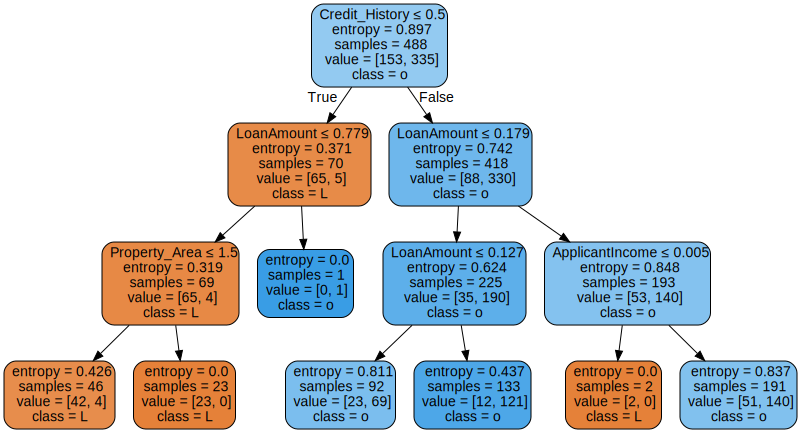

In [159]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=1)
dt_clf.fit(X_train, y_train)#, sample_weight=[0,1]) 

#Predict the response for test dataset
y_pred_dt = dt_clf.predict(X_test)
# Model Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy: ", accuracy_dt)


print(dt_clf.tree_.threshold)
print(dt_clf.tree_.impurity)

#tree visualization

import graphviz
dot_data = export_graphviz(dt_clf, out_file=None, 
                      feature_names=features,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("decision tree") 
graph

In [160]:
#Evaluation using Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_dt))

#Evaluation using Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred_dt)

              precision    recall  f1-score   support

           0       0.89      0.44      0.59        39
           1       0.79      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.84      0.71      0.73       123
weighted avg       0.82      0.80      0.78       123



array([[17, 22],
       [ 2, 82]], dtype=int64)

## KNN

Accuracy of KNN: 0.7723577235772358


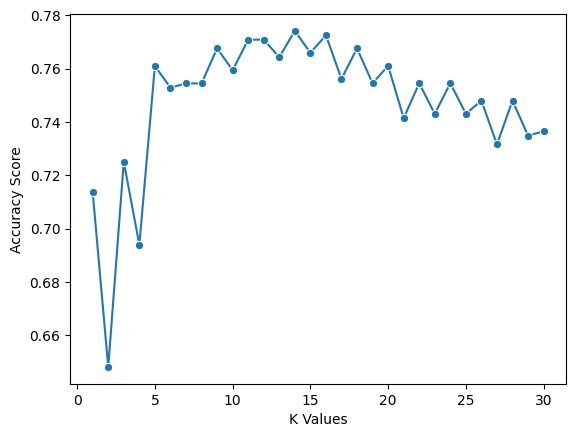

In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score

scores = []
k_values = [i for i in range (1,31)]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = model_selection.cross_val_score(knn, X, y, cv=5)  #cv already divides X and y
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")


best_index = np.argmax(scores)
best_k = k_values[best_index]
knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_clf.predict(X_test)
# Calculate the accuracy score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy of KNN:", accuracy_knn)

In [162]:
#Evaluation using Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_knn))

#Evaluation using Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred_knn)

              precision    recall  f1-score   support

           0       0.92      0.31      0.46        39
           1       0.75      0.99      0.86        84

    accuracy                           0.77       123
   macro avg       0.84      0.65      0.66       123
weighted avg       0.81      0.77      0.73       123



array([[12, 27],
       [ 1, 83]], dtype=int64)

## Naive Bayes

In [163]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_clf.predict(X_test)
# Calculate the accuracy score
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy_nb)


Accuracy: 0.7967479674796748


In [164]:
#Evaluation using Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_nb))

#Evaluation using Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred_nb)

              precision    recall  f1-score   support

           0       0.79      0.49      0.60        39
           1       0.80      0.94      0.86        84

    accuracy                           0.80       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.80      0.80      0.78       123



array([[19, 20],
       [ 5, 79]], dtype=int64)

## Model Evaluation

DT: 0.706875 (0.066634)
NB: 0.801798 (0.062228)
KNN3: 0.734744 (0.058481)
KNN5: 0.762559 (0.060450)
KNN10: 0.770756 (0.045583)


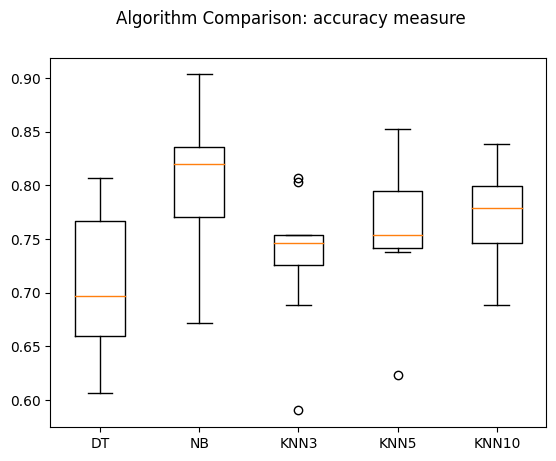

In [165]:
# compare models

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection


models = []
#models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeClassifier(criterion="entropy")))
models.append(('NB', GaussianNB()))
models.append(('KNN3', KNeighborsClassifier(n_neighbors=3)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5)))
models.append(('KNN10', KNeighborsClassifier(n_neighbors=10)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())  # the mean accuracy and the standard deviation accuracy
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison: accuracy measure')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Using Model on New Customer Data

In [153]:
NewCustomer = pd.read_csv("New Customer.csv", delimiter = ',', header = 0, index_col = 0)
max_accuracy = max(accuracy_dt, accuracy_knn, accuracy_nb)

if(max_accuracy == accuracy_dt):
    classi = dt_clf
elif(max_accuracy == accuracy_knn):
    classi = knn_clf
else:
    classi = nb_clf

loan_status_pred = classi.predict(TrainData[features])


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,1,0,0,0,0,0.070489,0.000000,0.198798,0.743590,1,2,1
LP001003,1,1,1,0,0,0.054830,0.036192,0.172214,0.743590,1,0,1
LP001005,1,1,0,0,1,0.035250,0.000000,0.082489,0.743590,1,2,1
LP001006,1,1,0,1,0,0.030093,0.056592,0.160637,0.743590,1,2,1
LP001008,1,0,0,0,0,0.072356,0.000000,0.191027,0.743590,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
LP002978,0,0,0,0,0,0.034014,0.000000,0.089725,0.743590,1,0,1
LP002979,1,1,3,0,0,0.048930,0.000000,0.044863,0.358974,1,0,1
LP002983,1,1,1,0,0,0.097984,0.005760,0.353111,0.743590,1,2,1
